In [9]:
import numpy as np
import numpy.linalg as npla
import matplotlib.pyplot as plt

from sympy import exp, sin, diff, symbols
from sympy.utilities.lambdify import lambdify

np.set_printoptions(linewidth=np.inf)

In [10]:
# defining range and precision
x_i, x_f = (0,1)
y_i, y_f = (0,1)

delta = .25

# number of points in x and y direction
x_points = int((x_f - x_i) // delta) + 1
y_points = int((y_f - y_i) // delta) + 1

x = np.linspace(x_i, x_f, x_points)
y = np.linspace(y_i, y_f, y_points)

nodes = x_points * y_points
nonboundary_nodes = (x_points - 2) * (y_points - 2)

In [11]:
# I'm assuming x_intervals = y_intervals

# discrete laplacian

# discrete second x partial derivative
laplacian_1d_m = np.zeros((x_points, x_points))
for i in range(1, x_points -1): laplacian_1d_m[i][i-1:i+2] = (1,-2,1)
laplacian_1d_m *= delta
laplacian_1d_m[0][0:4] = (2,-5,4,-1)
laplacian_1d_m[-1][-4:] = (-1,4,-5,2)

laplacian_1d_m /= delta ** 3

laplacian_1d_n = np.zeros((y_points, y_points))
for i in range(1, y_points -1): laplacian_1d_n[i][i-1:i+2] = (1,-2,1)
laplacian_1d_n *= delta
laplacian_1d_n[0][0:4] = (2,-5,4,-1)
laplacian_1d_n[-1][-4:] = (-1,4,-5,2)

laplacian_1d_n /= delta ** 3

A = np.kron(laplacian_1d_n, np.eye(x_points)) + np.kron(np.eye(y_points), laplacian_1d_m)

In [12]:
# source function

# ∇^2 u = Q(x)

xv, yv = np.meshgrid(x,y)

x_symbol, y_symbol = symbols('x y')

u_func = 1/2 * exp(2 * x_symbol) + 2 * sin(3 * y_symbol)
q_func = diff(u_func, x_symbol, x_symbol) + diff(u_func, y_symbol, y_symbol)

u_func = np.vectorize(lambdify([x_symbol,y_symbol], u_func))
u = u_func(xv, yv)
q_func = np.vectorize(lambdify([x_symbol,y_symbol], q_func))
Q = q_func(xv, yv)

g = []
for row in Q: g += list(row)

g = np.array(g)

In [13]:
# boundary conditions
"""
b_0       g_1(x_1)  ...  g_1(x_n-1)   b_1
f_0(y_n-1)          ...               f_1(y_n-1)
                    ... 
f_0(y_1)            ...               f_1(y_1)
b_2       g_0(x_1)  ...  g_0(x_n-1)   b_3
"""

f_0 = u_func(x_i, y)
f_1 = u_func(x_f, y)
g_0 = u_func(x, y_i)
g_1 = u_func(x, y_f)

BC = list(g_0)
for i, f in zip(f_0[1:-1], f_1[1:-1]): BC += [i] + [0] * (x_points - 2) + [f]
BC += list(g_1)
BC = np.array(BC)

In [14]:
# restriction and prolongation matricies
P = np.zeros((nodes, nonboundary_nodes))
curr_index = 0
for i in range(nodes):
    if i > x_points and i < nodes - x_points and i % x_points not in [0,x_points-1]:
        P[i, curr_index] = 1
        curr_index += 1

R = P.transpose()
print(P.shape)
print(R.shape)

(25, 9)
(9, 25)


In [15]:
# solving for z coords

"""
Let f = P * f_DOF + f_BC, A be the matrix representing the laplacian, and g be soruce function Q(x,y)

f = P * F _DOF + f_BC
A ( P * F _DOF + f_BC ) = g
AP * f_DOF = g - A * f_BC

Since AP is not square, we cannot find its inverse, so we multiply by the restriction matrix.

RAP * f_DOF = R ( g - A * f_BC)
f_DOF = (RAP).inv * [ R * ( g -  A * f_BC)]

This can be substituted into the original equation for f to give us an approximation for f.
"""

f = npla.inv(R @ A @ P) @ (R @ (g - A @ BC))

f = P @ f + BC

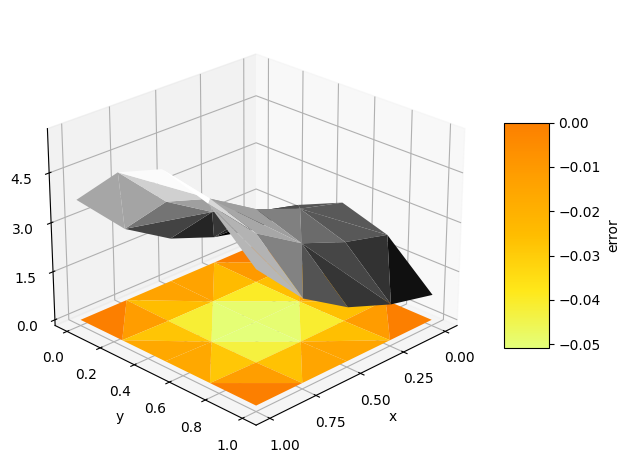

In [16]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

trisurf = ax.plot_trisurf(xv.flatten(), yv.flatten(), f,
                         cmap = plt.get_cmap('gist_gray'))

orig_trisurf = ax.plot_trisurf(xv.flatten(), yv.flatten(), u.flatten() - f,
                         cmap = plt.get_cmap('Wistia'))

#fig.colorbar(trisurf, ax = ax, shrink = 0.5, aspect = 5, label = "approximate solution")
fig.colorbar(orig_trisurf, ax = ax, shrink = 0.5, aspect = 5, label = "error")


# formatting the graph
ax.view_init(25, 45, 0)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))

fig.tight_layout()

plt.show()